# Analyse the Gephi blog

https://gephi.wordpress.com/tag/python/

In [2]:
import bs4
import pandas as pd

Data are manually downloaded as a html file

In [ ]:
blog = bs4.BeautifulSoup(open("./Data/gephi_blog_11072024.html","r"))
posts = blog.find_all("article")

### Craft extract function

In [ ]:
def extract(post):
    date = post.find("time")["datetime"]
    title = post.find("h1",{"class":"entry-title"}).text
    content = post.find("div",{"class":"entry-content"}).text
    return (date, title, content)

extract(posts[10])

('2021-07-19T15:10:55+01:00',
 'Gephi road map, Summer\xa02021',
 '\nThis road map states, in short, Gephi’s priorities, long-term and short-term goals, challenges in various areas, and way to go.\nProject vision\nGephi is multiplatform, open source, installable, extensible by the community, and with local-based files.\nGephi is an opinionated take on network analysis, and is not intended to be the only network analysis tool. Its focus is visual interaction, and a scalable workflow from 10 to 10,000,000 nodes (assuming enough computing power). Its core features are visualizing, filtering networks, and computing statistics. Gephi is exploration-oriented: visualize primarily for yourself, secondarily for others. More info on the community of Gephi users in this post.\nPriorities\nSustainability. Notably maintenance: Gephi needs to work before anything else. This includes: being easy to install (including Java) on all platforms, having the UI work in various screen resolutions and sizes, 

### Build corpus

In [ ]:
corpus = pd.DataFrame([extract(p) for p in posts], columns=["date", "title", "content"])
corpus["date"] = pd.to_datetime(corpus["date"])
corpus.shape

## Analytics

<Axes: xlabel='date'>

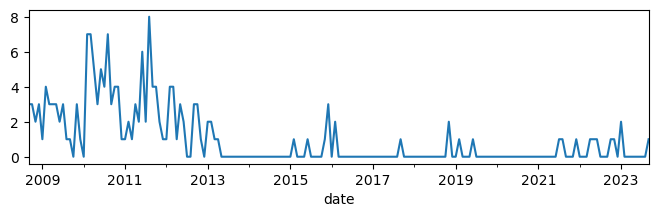

In [ ]:
corpus.set_index("date").resample("m")["content"].count().plot(figsize=(8,2))

## Who are the person mentionned in the blog ?

In [ ]:
from gliner import GLiNER

model = GLiNER.from_pretrained("urchade/gliner_large-v2.1")

pytorch_model.bin:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/anaconda3/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Cristiano Ronaldo => Person
5 February 1985 => Date
Portugal national team => Teams
Ronaldo => Person
Ballon d'Or awards => Award
UEFA Men's Player of the Year Awards => Award
European Golden Shoes => Award
UEFA Champions Leagues => Competitions
UEFA European Championship => Competitions
UEFA Nations League => Competitions
Ronaldo => Person


In [ ]:
model.predict_entities(corpus["content"].iloc[10], labels=["Locations"])

/opt/anaconda3/lib/python3.11/site-packages/gliner/modules/base.py:33: UserWarning: Sentence of length 862 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


[{'start': 1955,
  'end': 1965,
  'text': 'Copenhagen',
  'label': 'Locations',
  'score': 0.8013158440589905}]

In [ ]:
labels = ["People","Sotfware"]
t = corpus[0:10]["content"].apply(lambda x : model.predict_entities(x, labels, threshold=0.5))

In [ ]:
def split_text(text, chunck=300):
    chuncks = [text[i:i + chunck] for i in range(0, len(text), chunck)]
    return chuncks

def get_elements(text, labels):
    temp = [model.predict_entities(t, labels, threshold=0.5) for t in split_text(text)]
    temp = [[j["text"].lower(),j["label"].lower()] for i in temp for j in i]
    dic = {}
    for i in temp:
        if not i[1] in dic:
            dic[i[1]]=[i[0]]
        else:
            if not i[0] in dic[i[1]]:
                dic[i[1]].append(i[0])
    return dic

In [ ]:
labels = ["Surname","Sotfware"]

get_elements(corpus["content"].iloc[0], labels)

{'sotfware': ['gephi',
  'cytoscape',
  'nodexl',
  'graphext',
  'gephi app',
  'olkit',
  'plugin',
  'apache netbeans platform',
  'netbeans ide'],
 'surname': ['author',
  'mathieu jacomy',
  'eliver',
  'f',
  'bastian',
  'heymann',
  'jacomy',
  'ou',
  'eded',
  'gin',
  'levallois']}

### Use Llama3 with Ollama

In [149]:
import requests
import json

def split_text(text, chunck=300):
    chuncks = [text[i:i + chunck] for i in range(0, len(text), chunck)]
    return chuncks

def create_prompt(text):
    prompt = f"""You are a research assistant. I will give you a text, and I want you to list all the people with explicit names in it.
    Please return the result as a python list. Only return the result, add no other element. If there is no name, return an empty list []

    The text is the following. Find the names in it:

    {text}

    """
    return prompt

def request_llm(prompt):
    url = "http://0.0.0.0:11434/api/generate"
    headers = {"Content-Type":"application/json"} 
    data = {"model":"llama3", #"llama3" for the 8B,  "llama3:70b" for the 70b?
    "prompt":prompt,
    "stream":False}
    response = requests.post(url, headers=headers, data=json.dumps(data))
    return json.loads(response.content)["response"]

results = []
c = 0
for text in corpus["content"]:
    results.append([request_llm(create_prompt(t)) for t in split_text(text, 3000)])
    c+=1

The format is not very stable with llama3. Work around : extract the element of the list

In [152]:
import re
def extract_names(text):
    return re.findall("'(.*?)'", text)
t = [extract_names("-".join(i)) for i in results]

corpus["name_extraction"] = t
corpus.to_csv("blog_modified.csv")

### Analysis

In [14]:
import pandas as pd
import networkx as nx
corpus = pd.read_csv("blog_modified.csv")
corpus["date"] = pd.to_datetime(corpus["date"])

Manual cleaning of the names :

- polysemia
- removing generic First names & artefacts

In [54]:
# Get the distribution of elements
#pd.Series([j for i in t for j in i]).value_counts().to_csv("Names_to_reco.csv")

names = pd.read_csv("./Names_cleaned.csv")
names["reco"] = names["Unnamed: 0"].replace(dict(names.set_index("Unnamed: 0")["reco"].dropna()))
names.columns = ["name", "count", "reco"]
f = ~ names["name"].str.contains("\.")
names = dict(names[f].set_index("name")["reco"])


Build a network per blog post

In [55]:
import networkx as nx
from itertools import combinations

def is_name(text, names=names):
    return list(set([names[i] for i in names if i in text]))

reseau = nx.Graph()

for i, post in corpus.sort_values("date").iterrows():
    actors  = is_name(post["content"], names)
    for a in actors:
        if not reseau.has_node(a):
            reseau.add_node(a, weight=0, year = float(post["date"].year))
        reseau.nodes[a]["weight"]+=1
    for a,b in combinations(actors,2):
        if not reseau.has_edge(a,b):
            reseau.add_edge(a,b,weight=0)
        reseau.edges[a,b]["weight"]+=1
    
print(reseau)

Graph with 114 nodes and 529 edges


In [57]:
from ipysigma import Sigma
Sigma(reseau, node_size="weight", node_color="year", node_color_gradient='Viridis')

Sigma(nx.Graph with 114 nodes and 529 edges)